# Vision Transformer (ViT)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
#|export
from fastai.vision.all import *
from fastai.distributed import *
import timm

In [3]:
#|export
set_seed(42)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [5]:
#|export
dataroot_path = Path('/home/exsdatalab/data/surgvu24')

In [6]:
#|export
images_df=pd.read_csv(dataroot_path/'frames_info.csv')

In [7]:
len(images_df)

279175

In [8]:
# Step 1: Apply the label mapping (assuming this has already been done in the previous step)
label_mapping = {
    "Range of motion": "range_of_motion",
    "Rectal artery/vein": "rectal_artery_vein",
    "Retraction and collision avoidance": "retraction_collision_avoidance",
    "Skills application": "skills_application",
    "Suspensory ligaments": "suspensory_ligaments",
    "Suturing": "suturing",
    "Uterine horn": "uterine_horn",
    "Other/Unannotated": "other"
}

# Apply the mapping to the task_label column in images_df
images_df['task_label'] = images_df['task_label'].map(label_mapping)


In [9]:
# Print unique labels after modification
task_labels = images_df['task_label'].unique()
list(task_labels)

['other',
 'skills_application',
 'uterine_horn',
 'suspensory_ligaments',
 'rectal_artery_vein',
 'suturing',
 'retraction_collision_avoidance',
 'range_of_motion']

In [10]:
#|export
def splitter(df):
    train = df.index[~df['valid']].tolist()
    valid = df.index[df['valid']].tolist()
    return train, valid

In [11]:
#|export
def get_image(r): 
    return str(dataroot_path) + '/frames/' + r['filename'] + '.jpg'

In [12]:
#|export
def get_label(r): return r['task_label']

In [13]:
#|export
def get_dblock(item_tfms, batch_tfms):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock(task_labels)),  # Ensure the data types are correct
                       get_x=get_image,
                       get_y=get_label,
                       splitter=splitter,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)
    return dblock

In [14]:
#|export
dblock = get_dblock(
    item_tfms=Resize((224, 224), method=ResizeMethod.Squish),
    batch_tfms=[*aug_transforms(size=(224, 224), min_scale=1), Normalize.from_stats(*imagenet_stats)]
)

dls = dblock.dataloaders(images_df, bs=64, seed=42)

In [15]:
dls.vocab

['other', 'range_of_motion', 'rectal_artery_vein', 'retraction_collision_avoidance', 'skills_application', 'suspensory_ligaments', 'suturing', 'uterine_horn']

In [16]:
learn = vision_learner(dls, 'vit_tiny_patch16_224', 
                       metrics=[accuracy, error_rate,
                                Precision(average='macro'),
                                Recall(average='macro'),
                                F1Score(average='macro')
                                ]).to_fp16()

In [22]:
learn.model[:-1]

Sequential(
  (0): TimmBody(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_featu

In [20]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 192 x 14 x 14  
Conv2d                                    147648     False     
Identity                                                       
Dropout                                                        
Identity                                                       
Identity                                                       
LayerNorm                                 384        True      
____________________________________________________________________________
                     64 x 197 x 576      
Linear                                    111168     False     
Identity                                                       
Identity                                                       
Linear                                    37056      False     
Dropout                                                        
Identity                  

SuggestedLRs(valley=0.001737800776027143)

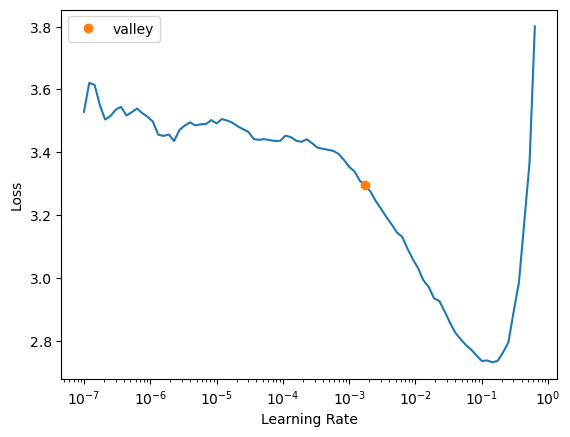

In [21]:
learn.lr_find()

In [22]:
learn.freeze()
learn.fit_one_cycle(10, 1e-3) 

epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,recall_score,f1_score,time
0,0.771860,0.737226,0.739396,0.260604,0.719937,0.695445,0.676485,03:54
1,0.529298,0.615684,0.779556,0.220444,0.735407,0.731258,0.711895,03:50
2,0.473523,0.574500,0.791981,0.208019,0.764039,0.745898,0.735015,03:49
3,0.427473,0.571423,0.798102,0.201898,0.758897,0.755207,0.742746,03:51
4,0.409561,0.553029,0.805650,0.194350,0.762089,0.772263,0.759096,03:50
5,0.385859,0.560529,0.805683,0.194317,0.762356,0.783907,0.767311,03:49
6,0.378446,0.550307,0.807160,0.192840,0.766251,0.779479,0.763859,03:49
7,0.347409,0.552193,0.808835,0.191165,0.775557,0.761482,0.759852,03:55
8,0.357810,0.552877,0.808735,0.191265,0.772792,0.763432,0.761990,04:03
9,0.357798,0.548553,0.809681,0.190319,0.775055,0.763002,0.762623,03:45


SuggestedLRs(valley=5.248074739938602e-05)

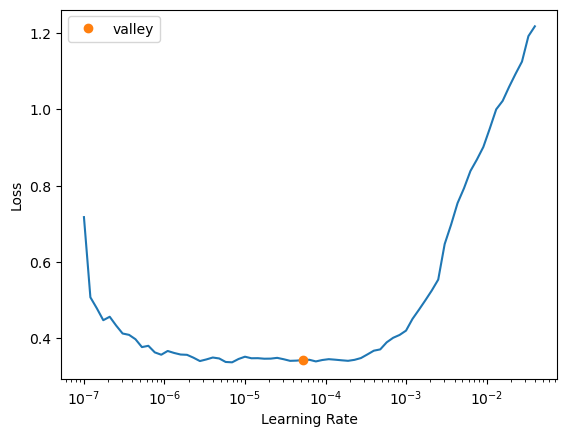

In [23]:
learn.unfreeze()
learn.lr_find()

In [24]:
learn.fit_one_cycle(20, slice(1e-3/400, 1e-3/4))     

epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,recall_score,f1_score,time
0,0.350986,0.549366,0.810361,0.189639,0.774158,0.771153,0.766398,04:12
1,0.358408,0.548246,0.811390,0.188610,0.774924,0.775578,0.771544,04:10
2,0.331443,0.551326,0.811423,0.188577,0.778546,0.766443,0.765794,04:11
3,0.304719,0.555827,0.814044,0.185956,0.772525,0.782019,0.772648,04:10
4,0.318023,0.547053,0.817428,0.182572,0.783668,0.790192,0.781246,10:20
5,0.295899,0.564392,0.813961,0.186039,0.782571,0.756260,0.765903,08:34
6,0.261934,0.563952,0.816018,0.183982,0.771193,0.802646,0.783996,09:55
7,0.270974,0.572038,0.816018,0.183982,0.784279,0.778861,0.777334,09:23
8,0.231577,0.610761,0.814044,0.185956,0.783721,0.772727,0.775307,10:31
9,0.241823,0.613755,0.815603,0.184397,0.778872,0.779750,0.777452,09:46


/home/exsdatalab/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


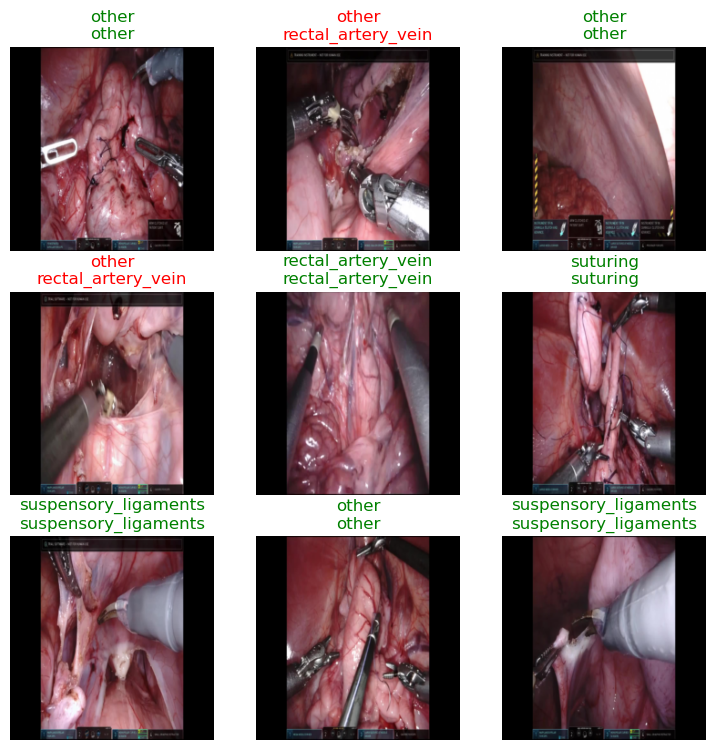

In [26]:
learn.show_results()

In [25]:
#|export
learn.path = Path('models/baseline')
learn.export("vit_tiny.pkl")